## Callin Switzer
## Build Residual plots for nnet output

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
import time
from datetime import datetime
import sys
import csv
import seaborn as sns
import scipy.io
import subprocess
import csv
import pickle

from matplotlib.ticker import ScalarFormatter

import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")

print(sys.version, "\n")

now = datetime.now()
print("last run on " + str(now))

#%qtconsole

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
randomRawData = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/PythonGeneratedData'

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)
    
# open file explorer
# aa = r'explorer /select,"'
# subprocess.Popen(str(aa + figDir + '\"'))
# subprocess.Popen(str(aa + dataDir + '\"'))

C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-01-01 07:54:42.795287


In [2]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


In [3]:
# import custom Utils functions
from DeepLearningUtils import *

TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-01-01 07:54:42.841135


In [4]:
# load test data
testDF = pd.read_hdf(os.path.join(dataOutput, "concatenatedRandomICs_test.h5"), key = "data")

In [5]:
testDF.head()

,x0,xf,xd0,xdf,y0,yf,yd0,ydf,theta0,thetaf,thetad0,thetadf,phi0,phif,phid0,phidf,F,alpha,tau0
0,0.0,9.347785,541.507416,414.083042,0.0,7.688051,502.568101,287.383793,6.272284,6.544707,-17.699701,18.810204,0.450877,0.654225,14.035800,15.213214,11219.837510,3.894620,49507.776091
1,0.0,23.603876,1409.737698,947.641985,0.0,23.633075,995.727369,1364.057322,2.831231,3.124010,19.846242,13.427370,1.913727,2.267903,17.112298,16.578990,32085.414060,5.663013,-44535.446002
2,0.0,11.786005,880.949432,309.848297,0.0,2.540601,178.694952,90.052276,3.740158,3.401310,-20.840242,-24.537621,1.081307,0.827989,-1.641278,-20.193446,30105.498810,5.887696,-61184.629551
3,0.0,-33.335655,-1401.856110,-1968.245123,0.0,-30.535096,-1363.320818,-1698.626961,3.084163,2.988790,5.480075,2.689363,4.572172,4.439168,-20.266189,0.809786,35050.797718,0.636051,27737.765285
4,0.0,26.205825,1420.324857,1235.582609,0.0,13.510248,545.096025,821.878809,4.596070,4.434904,-14.273627,-8.022537,5.882793,5.767939,-3.849331,-5.675035,18264.151609,3.822985,-33676.774825


In [6]:
# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "xf" : "x_99", "yf" : "y_99", "phif" : "phi_99", "thetaf" : "theta_99", 
                        "xd0" : "x_dot_0", "yd0" : "y_dot_0", "phid0" : "phi_dot_0", "thetad0": "theta_dot_0", 
                        "xdf" : "x_dot_99", "ydf": "y_dot_99", "phidf": "phi_dot_99", "thetadf": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [7]:
# convert to fx and fy
testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)

In [8]:
# make datasets for nnet
X = testDF.loc[:, ["x_0", "y_0", "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [9]:
# scale data
scalerfileX = 'scalerX.pkl'
scalerfileY = 'scalerY.pkl'

scalerX = pickle.load(open(os.path.join(dataOutput, scalerfileX), 'rb'))
X_scaled = scalerX.transform(X)

scalerY = pickle.load(open(os.path.join(dataOutput, scalerfileY), 'rb'))
Y_scaled = scalerY.transform(Y)

# Keras Models

In [10]:
# load model
# check to see if model saved: 
K.clear_session()
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model_400Units.h5'))

In [11]:
nnpreds = model.predict(X_scaled[ :])

In [12]:
# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

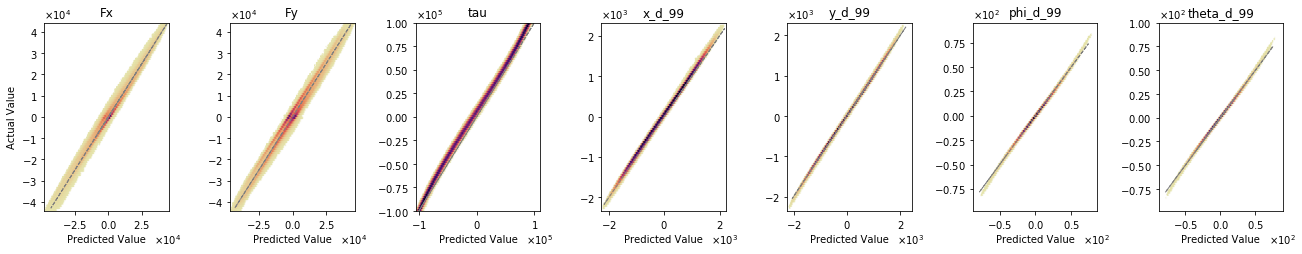

In [13]:
plt.close("all")
fig, axs = plt.subplots(1,7, figsize=np.array((20, 4)) / 1.1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Y.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")
        axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='both', scilimits=(3,4))
        t = axs[ii].xaxis.get_offset_text()
        t.set_x(1.1)
        t.set_y(0.5)
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Y.iloc[0:1000,ii], Y.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
plt.tight_layout()

#fig.savefig(os.path.join(figDir, "NNPreds_Fig1.png"), dpi = 500, bbox_inches='tight')
# fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin_loadedModel.svg"),bbox_inches='tight')

# residual plots

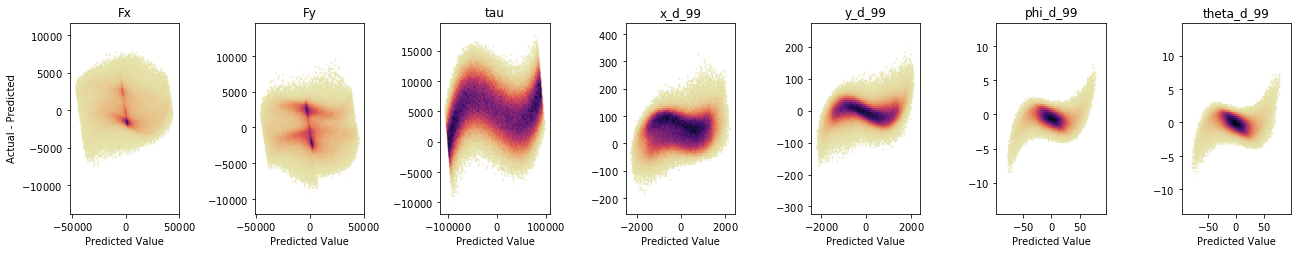

In [14]:
plt.close("all")
fig, axs = plt.subplots(1,7, figsize=np.array((20, 4)) / 1.1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2


for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Y.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")
        axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#         axs[ii].ticklabel_format(style='sci',  axis='both', scilimits=(3,4))
#         t = axs[ii].xaxis.get_offset_text()
#         t.set_x(1.1)
#         t.set_y(0.5)
        if(ii == 0):
            axs[ii].set_ylabel("Actual - Predicted")
        axs[ii].set_title(nms2[ii])
        #axs[ii].plot(Y.iloc[0:1000,ii], Y.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
plt.tight_layout()

#fig.savefig(os.path.join(figDir, "NNPreds_resids_Fig1.png"), dpi = 500, bbox_inches='tight')
# fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin_loadedModel.svg"),bbox_inches='tight')

In [15]:
nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2 = [nms2[ii].replace("_", "") for ii in range(len(nms2))]
nms2 = [nms2[ii].replace("99", "9") for ii in range(len(nms2))]
nms2 = ["     " + nms2[ii] for ii in range(len(nms2))]
nms2

['     Fx',
 '     Fy',
 '     tau',
 '     xd9',
 '     yd9',
 '     phid9',
 '     thetad9']

YES


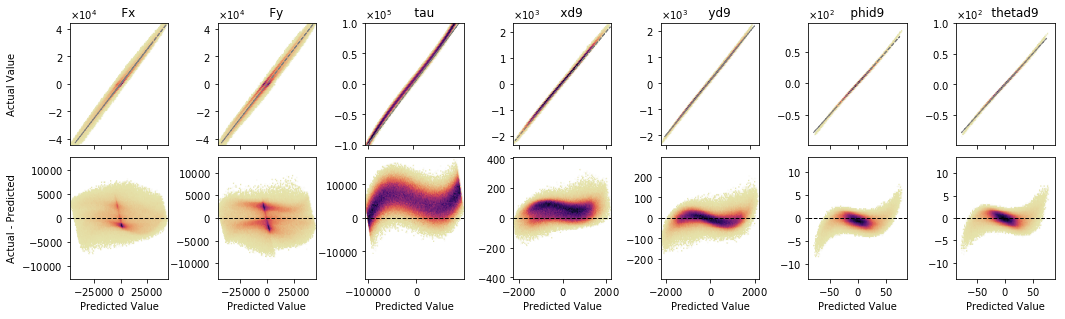

In [28]:
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()


# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Y.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
#         axs[ii].set_xlabel("Predicted Value")
#         axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
            axs[ii].yaxis.set_label_coords(-0.535,0.5)
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Y.iloc[0:1000,ii], Y.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Y.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Y.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Y.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            print("YES")
            axs[jj].set_ylabel("Actual - Predicted")
        #axs[jj].set_title(nms2[ii])
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
#plt.tight_layout()
fig.savefig(os.path.join(figDir, "NNPreds_resids_combined_Fig1.png"), dpi = 500, bbox_inches='tight')


In [29]:
# calculate mean squared error

In [30]:
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

In [31]:
for ii in range(len(nms)):
    #np.sqrt(mean_squared_error(Ytest.iloc[0:1000,ii], nnpreds_unscaled[:,ii]))
    print(r2_score(Y.iloc[0:1000000,ii], nnpreds_unscaled[:,ii]), nms[ii])

0.9830127814092415 Fx
0.9812096474162687 Fy
0.9889551906364958 tau
0.9946201194227348 x_dot_99
0.9988864990213081 y_dot_99
0.996878104983364 phi_dot_99
0.9973878084356691 theta_dot_99


# Make new data frame to put back into simulation

In [33]:
TestPreds = pd.DataFrame(nnpreds_unscaled, columns = Y.columns)
TestPreds.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-7270.663574,-11222.940430,41779.531250,431.100739,286.793213,18.787769,21.807661
1,28320.859375,-14925.699219,-53341.394531,881.637390,1388.702393,17.693207,13.812419
2,30088.263672,-9140.199219,-71866.242188,272.308563,80.476753,-20.054775,-25.380537
3,27464.316406,19522.406250,27833.310547,-1944.185791,-1672.597778,1.120616,2.428478
4,-13513.797852,-14222.883789,-39307.789062,1192.818726,851.121033,-4.884992,-7.559634


In [35]:
TestInput = pd.DataFrame(X, columns = X.columns).reset_index(drop = True)
TestInput.head()

,x_0,y_0,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.0,0.0,0.450877,6.272284,9.347785,7.688051,0.654225,6.544707,541.507416,502.568101,14.035800,-17.699701
1,0.0,0.0,1.913727,2.831231,23.603876,23.633075,2.267903,3.124010,1409.737698,995.727369,17.112298,19.846242
2,0.0,0.0,1.081307,3.740158,11.786005,2.540601,0.827989,3.401310,880.949432,178.694952,-1.641278,-20.840242
3,0.0,0.0,4.572172,3.084163,-33.335655,-30.535096,4.439168,2.988790,-1401.856110,-1363.320818,-20.266189,5.480075
4,0.0,0.0,5.882793,4.596070,26.205825,13.510248,5.767939,4.434904,1420.324857,545.096025,-3.849331,-14.273627


In [36]:
# F will be the same in any quadrant

TestPreds["F"] = np.sqrt(TestPreds["Fx"]**2 + TestPreds["Fy"]**2)

# trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
# trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

In [37]:
TestPreds.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,F
0,-7270.663574,-11222.940430,41779.531250,431.100739,286.793213,18.787769,21.807661,13372.245117
1,28320.859375,-14925.699219,-53341.394531,881.637390,1388.702393,17.693207,13.812419,32013.242188
2,30088.263672,-9140.199219,-71866.242188,272.308563,80.476753,-20.054775,-25.380537,31445.935547
3,27464.316406,19522.406250,27833.310547,-1944.185791,-1672.597778,1.120616,2.428478,33695.890625
4,-13513.797852,-14222.883789,-39307.789062,1192.818726,851.121033,-4.884992,-7.559634,19619.203125


In [38]:
# calculate alpha
def quadrant(Fx, Fy):
    if (Fx >= 0) & (Fy >= 0):
        q = 1
    elif (Fx < 0) & (Fy >= 0):
        q = 2
    elif (Fx < 0) & (Fy < 0):
        q = 3
    elif (Fx >= 0) & (Fy < 0):
        q = 4
    else:
        q = 999999
    return(q)



In [39]:
TestPreds["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(TestPreds["Fx"], TestPreds["Fy"])]

In [40]:
TestPreds.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,F,quadrant
0,-7270.663574,-11222.940430,41779.531250,431.100739,286.793213,18.787769,21.807661,13372.245117,3
1,28320.859375,-14925.699219,-53341.394531,881.637390,1388.702393,17.693207,13.812419,32013.242188,4
2,30088.263672,-9140.199219,-71866.242188,272.308563,80.476753,-20.054775,-25.380537,31445.935547,4
3,27464.316406,19522.406250,27833.310547,-1944.185791,-1672.597778,1.120616,2.428478,33695.890625,1
4,-13513.797852,-14222.883789,-39307.789062,1192.818726,851.121033,-4.884992,-7.559634,19619.203125,3


In [41]:
def angleCalc(Fx, Fy, q):
    fx = np.abs(Fx)
    fy = np.abs(Fy)
    
    if q == 1:
        alpha = np.arctan(fy/fx)
    elif q == 2:
        alpha = np.pi - np.arctan(fy/fx)
    elif q == 3: 
        alpha = np.pi + np.arctan(fy/fx)
    elif q == 4:
        alpha = (2*np.pi) - np.arctan(fy/fx)
    return(alpha)

In [42]:
TestPreds["alpha"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(TestPreds["Fx"], TestPreds["Fy"], TestPreds["quadrant"])]

In [43]:
TestPreds.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,F,quadrant,alpha
0,-7270.663574,-11222.940430,41779.531250,431.100739,286.793213,18.787769,21.807661,13372.245117,3,4.137534
1,28320.859375,-14925.699219,-53341.394531,881.637390,1388.702393,17.693207,13.812419,32013.242188,4,5.798155
2,30088.263672,-9140.199219,-71866.242188,272.308563,80.476753,-20.054775,-25.380537,31445.935547,4,5.988265
3,27464.316406,19522.406250,27833.310547,-1944.185791,-1672.597778,1.120616,2.428478,33695.890625,1,0.617956
4,-13513.797852,-14222.883789,-39307.789062,1192.818726,851.121033,-4.884992,-7.559634,19619.203125,3,3.952550


In [44]:
TestPredsComb = pd.concat([TestPreds, TestInput], axis = 1)

In [45]:
TestPredsComb.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,F,quadrant,alpha,...,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,-7270.663574,-11222.940430,41779.531250,431.100739,286.793213,18.787769,21.807661,13372.245117,3,4.137534,...,0.450877,6.272284,9.347785,7.688051,0.654225,6.544707,541.507416,502.568101,14.035800,-17.699701
1,28320.859375,-14925.699219,-53341.394531,881.637390,1388.702393,17.693207,13.812419,32013.242188,4,5.798155,...,1.913727,2.831231,23.603876,23.633075,2.267903,3.124010,1409.737698,995.727369,17.112298,19.846242
2,30088.263672,-9140.199219,-71866.242188,272.308563,80.476753,-20.054775,-25.380537,31445.935547,4,5.988265,...,1.081307,3.740158,11.786005,2.540601,0.827989,3.401310,880.949432,178.694952,-1.641278,-20.840242
3,27464.316406,19522.406250,27833.310547,-1944.185791,-1672.597778,1.120616,2.428478,33695.890625,1,0.617956,...,4.572172,3.084163,-33.335655,-30.535096,4.439168,2.988790,-1401.856110,-1363.320818,-20.266189,5.480075
4,-13513.797852,-14222.883789,-39307.789062,1192.818726,851.121033,-4.884992,-7.559634,19619.203125,3,3.952550,...,5.882793,4.596070,26.205825,13.510248,5.767939,4.434904,1420.324857,545.096025,-3.849331,-14.273627


In [46]:
TestPredsComb.rename(index=str, columns={"F": "F_pred", "alpha": "alpha_pred", "tau":"tau_pred"}, inplace=True)

In [47]:
TestPredsComb.head()

,Fx,Fy,tau_pred,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,F_pred,quadrant,alpha_pred,...,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,-7270.663574,-11222.940430,41779.531250,431.100739,286.793213,18.787769,21.807661,13372.245117,3,4.137534,...,0.450877,6.272284,9.347785,7.688051,0.654225,6.544707,541.507416,502.568101,14.035800,-17.699701
1,28320.859375,-14925.699219,-53341.394531,881.637390,1388.702393,17.693207,13.812419,32013.242188,4,5.798155,...,1.913727,2.831231,23.603876,23.633075,2.267903,3.124010,1409.737698,995.727369,17.112298,19.846242
2,30088.263672,-9140.199219,-71866.242188,272.308563,80.476753,-20.054775,-25.380537,31445.935547,4,5.988265,...,1.081307,3.740158,11.786005,2.540601,0.827989,3.401310,880.949432,178.694952,-1.641278,-20.840242
3,27464.316406,19522.406250,27833.310547,-1944.185791,-1672.597778,1.120616,2.428478,33695.890625,1,0.617956,...,4.572172,3.084163,-33.335655,-30.535096,4.439168,2.988790,-1401.856110,-1363.320818,-20.266189,5.480075
4,-13513.797852,-14222.883789,-39307.789062,1192.818726,851.121033,-4.884992,-7.559634,19619.203125,3,3.952550,...,5.882793,4.596070,26.205825,13.510248,5.767939,4.434904,1420.324857,545.096025,-3.849331,-14.273627


In [48]:
TestPredsComb.drop(['Fx', 'Fy', "quadrant"], axis=1, inplace = True)
TestPredsComb.head()

,tau_pred,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,F_pred,alpha_pred,x_0,y_0,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,41779.531250,431.100739,286.793213,18.787769,21.807661,13372.245117,4.137534,0.0,0.0,0.450877,6.272284,9.347785,7.688051,0.654225,6.544707,541.507416,502.568101,14.035800,-17.699701
1,-53341.394531,881.637390,1388.702393,17.693207,13.812419,32013.242188,5.798155,0.0,0.0,1.913727,2.831231,23.603876,23.633075,2.267903,3.124010,1409.737698,995.727369,17.112298,19.846242
2,-71866.242188,272.308563,80.476753,-20.054775,-25.380537,31445.935547,5.988265,0.0,0.0,1.081307,3.740158,11.786005,2.540601,0.827989,3.401310,880.949432,178.694952,-1.641278,-20.840242
3,27833.310547,-1944.185791,-1672.597778,1.120616,2.428478,33695.890625,0.617956,0.0,0.0,4.572172,3.084163,-33.335655,-30.535096,4.439168,2.988790,-1401.856110,-1363.320818,-20.266189,5.480075
4,-39307.789062,1192.818726,851.121033,-4.884992,-7.559634,19619.203125,3.952550,0.0,0.0,5.882793,4.596070,26.205825,13.510248,5.767939,4.434904,1420.324857,545.096025,-3.849331,-14.273627


In [49]:
cols= ['x_0', 'y_0', 'phi_0', 'theta_0', 
       'x_dot_0', 'y_dot_0', 'phi_dot_0', 'theta_dot_0', 
       'F_pred', 'alpha_pred', 'tau_pred', 
      'x_99', 'y_99', 'phi_99', 'theta_99', 
      'x_dot_99', 'y_dot_99', 'phi_dot_99', 'theta_dot_99' ]

In [50]:
tc2 = TestPredsComb.loc[:, cols]
tc2.head()

,x_0,y_0,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,F_pred,alpha_pred,tau_pred,x_99,y_99,phi_99,theta_99,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,0.0,0.0,0.450877,6.272284,541.507416,502.568101,14.035800,-17.699701,13372.245117,4.137534,41779.531250,9.347785,7.688051,0.654225,6.544707,431.100739,286.793213,18.787769,21.807661
1,0.0,0.0,1.913727,2.831231,1409.737698,995.727369,17.112298,19.846242,32013.242188,5.798155,-53341.394531,23.603876,23.633075,2.267903,3.124010,881.637390,1388.702393,17.693207,13.812419
2,0.0,0.0,1.081307,3.740158,880.949432,178.694952,-1.641278,-20.840242,31445.935547,5.988265,-71866.242188,11.786005,2.540601,0.827989,3.401310,272.308563,80.476753,-20.054775,-25.380537
3,0.0,0.0,4.572172,3.084163,-1401.856110,-1363.320818,-20.266189,5.480075,33695.890625,0.617956,27833.310547,-33.335655,-30.535096,4.439168,2.988790,-1944.185791,-1672.597778,1.120616,2.428478
4,0.0,0.0,5.882793,4.596070,1420.324857,545.096025,-3.849331,-14.273627,19619.203125,3.952550,-39307.789062,26.205825,13.510248,5.767939,4.434904,1192.818726,851.121033,-4.884992,-7.559634


In [51]:
tc2.rename(columns = {"x_dot_99": "x_dot_99_pred", 
                     "y_dot_99": "y_dot_99_pred", 
                     "theta_dot_99": "theta_dot_99_pred", 
                     "phi_dot_99": "phi_dot_99_pred"}, inplace = True)
tc2.head()

,x_0,y_0,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,F_pred,alpha_pred,tau_pred,x_99,y_99,phi_99,theta_99,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,0.0,0.0,0.450877,6.272284,541.507416,502.568101,14.035800,-17.699701,13372.245117,4.137534,41779.531250,9.347785,7.688051,0.654225,6.544707,431.100739,286.793213,18.787769,21.807661
1,0.0,0.0,1.913727,2.831231,1409.737698,995.727369,17.112298,19.846242,32013.242188,5.798155,-53341.394531,23.603876,23.633075,2.267903,3.124010,881.637390,1388.702393,17.693207,13.812419
2,0.0,0.0,1.081307,3.740158,880.949432,178.694952,-1.641278,-20.840242,31445.935547,5.988265,-71866.242188,11.786005,2.540601,0.827989,3.401310,272.308563,80.476753,-20.054775,-25.380537
3,0.0,0.0,4.572172,3.084163,-1401.856110,-1363.320818,-20.266189,5.480075,33695.890625,0.617956,27833.310547,-33.335655,-30.535096,4.439168,2.988790,-1944.185791,-1672.597778,1.120616,2.428478
4,0.0,0.0,5.882793,4.596070,1420.324857,545.096025,-3.849331,-14.273627,19619.203125,3.952550,-39307.789062,26.205825,13.510248,5.767939,4.434904,1192.818726,851.121033,-4.884992,-7.559634


In [53]:
tc2.to_csv(os.path.join(dataOutput, "NNpreds_RandomICs.csv"), index = False)

In [54]:
tc2.shape

(1000000, 19)

In [56]:
X.shape

(1000000, 12)

In [57]:

tc_sm =  tc2.sample(n=1000, random_state = 902902)
tc_sm.to_csv(os.path.join(dataOutput, "NNpreds_small_RandomICs.csv"), index = False)

In [ ]:
# check alpha on trainDf
trainDF2["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(trainDF2["Fx"], trainDF2["Fy"])]

trainDF2["alphaCalc"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(trainDF2["Fx"], trainDF2["Fy"], trainDF2["quadrant"])]

In [ ]:
trainDF2.loc[:, ["alpha", "alphaCalc"]].head()

In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,int(len(Y.columns)/2), figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.3)
fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].scatter(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], s = 1, alpha = 0.1 )
        axs[ii].set_xlabel("Predicted Value (un-scaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(un-scaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(Ytest.iloc[:,ii], Ytest.iloc[:,ii], 'b')
    except:
        pass

    
fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy.png"), dpi = 120, bbox_inches='tight')

In [ ]:
Ytest.head()

In [ ]:
Xtest.head()

In [ ]:
# refref: idea - predict whole paths, rather than just the endpoint

In [ ]:
plt.close("all")
fig, axs = plt.subplots(1,3, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.3)
fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = ["Fx", "Fy", "tau"]


# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(3):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest_scaled[:,ii],x = nnpreds[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value (scaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(scaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(Ytest_scaled[:,ii], Ytest_scaled[:,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin.png"), dpi = 120, bbox_inches='tight')

In [ ]:
bf2[['simNum', 'timestep']] = bf2[['simNum', 'timestep']].astype(int)

bf2['count'] = bf2.groupby(["simNum", "timestep"]).cumcount()

bf2.head()

bf2.tail()

sdf = bf2.loc[(bf2["count"] == 0) | (bf2["count"] == 99), :]
sdf.head()

ss = sdf.pivot_table(index='simNum', columns = "count",aggfunc='first')
ss.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in ss.columns]
ss["simNum"] = ss.index
ss.index.name = None
ss.head()

np.array(ss).shape

np.vstack([np.array(ss), np.array(ss)]).shape